In [51]:
#linear regression 

import tensorflow as tf; import keras
import numpy as np; 
from keras import models
from numpy import zeros, newaxis
import matplotlib.pyplot as plt
import scipy
import hdf5storage
from scipy import stats
from keras import layers, regularizers, callbacks
import pandas as pd 

import scipy; import hdf5storage; import scipy.stats
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D,LeakyReLU, BatchNormalization, Dropout
from keras.models import Sequential

from tqdm import tqdm
import pickle
from keras.utils import plot_model

from scipy.stats import pearsonr

COLOR = 'black'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR
plt.rcParams['figure.facecolor'] = 'white'



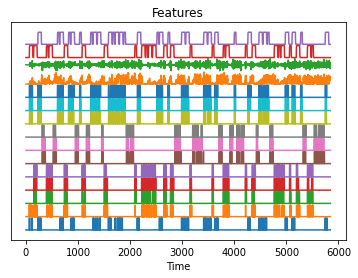

In [52]:
# import data from .mat file, have to use hdf5storage package for matlab 7.3 files
file_name_day3 = '/Users/nakulyadav/Desktop/data/AnalysisNY/practiceCNNGLM2.mat'

dffCNN_content = hdf5storage.loadmat(file_name_day3)

#gives me a designMatris (features x time) and dff matrix (neuron x time)

featureMat = np.asarray(dffCNN_content['designMat'])
neuronMat = np.asarray(dffCNN_content['dfT'])

#all features between 0 and 1
mins = np.repeat(np.min(featureMat, axis = 1).reshape(15,1),featureMat.shape[1], axis=1)
featureMat = featureMat - mins
maxes = np.repeat(np.max(featureMat, axis = 1).reshape(15,1),featureMat.shape[1], axis=1)
featureMat = featureMat/maxes



for i in range(featureMat.shape[0]):
    plt.plot(featureMat[i,] + 1.1*i)
plt.xlabel('Time')
plt.title('Features')

ax = plt.gca()
ax.axes.yaxis.set_visible(False)

plt.show()


In [55]:
num_range = np.asarray(range(0,numImage))
train_spl = num_range[np.mod(num_range,frameNum*5)<=frameNum*4]
test_spl = num_range[np.mod(num_range,frameNum*5)>frameNum*4]

train_spl= train_spl+30
test_spl = test_spl+30

print(train_spl)

[  30   31   32 ... 5842 5843 5844]


In [57]:
#SIMPLE LINEAR REGRESSION 
from sklearn.linear_model import LinearRegression

correlation =[]

X_train = featureMat[:,train_spl]
X_test = featureMat[:,test_spl]


for i in range(numNeurons):
    y_train = neuronMat[i,train_spl]
    y_test = neuronMat[i,test_spl]
    reg = LinearRegression().fit(np.transpose(X_train), np.transpose(y_train))
    ypred = reg.predict(np.transpose(X_test))
    pearson_results = pearsonr(ypred,y_test)
    correlation.append(pearson_results)
    pd.DataFrame(correlation).to_csv('Total_Neuron_Pearson_R.csv')  #FILE SAVED IN

In [47]:
from sklearn.linear_model import LinearRegression

X_train = featureMat[:,train_spl]
X_test = featureMat[:,test_spl]
y_train = neuronMat[548,train_spl]
y_test = neuronMat[548,test_spl]
reg = LinearRegression().fit(np.transpose(X_train), np.transpose(y_train))
ypred = reg.predict(np.transpose(X_test))

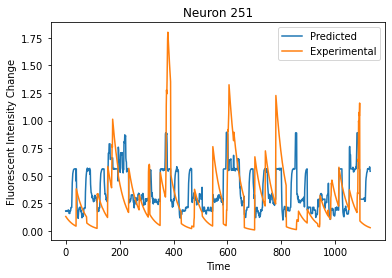

In [48]:
plt.plot((ypred))
plt.plot((y_test))
plt.xlabel('Time')
plt.ylabel('Fluorescent Intensity Change')
plt.title('Neuron %d' % 251)
plt.legend(['Predicted', 'Experimental'])


plt.show()

In [49]:
pearsonr(ypred,y_test)

(0.3326393736415659, 1.2656770375908233e-30)

1.9543251685646335


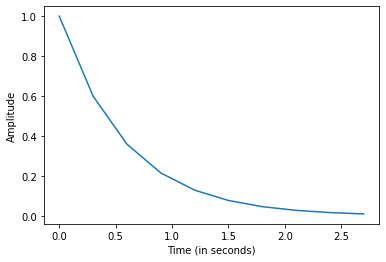

In [58]:
#CONVOLUTION WINDOW

from scipy import signal

M = 10
x = np.arange(0, 3, 0.3)
tau2 = -(M-1) / np.log(0.01)
window2 = signal.exponential(M, 0, tau2, False)
plt.figure()
plt.plot(x,window2)
plt.ylabel("Amplitude")
plt.xlabel("Time (in seconds)")
print(tau2)

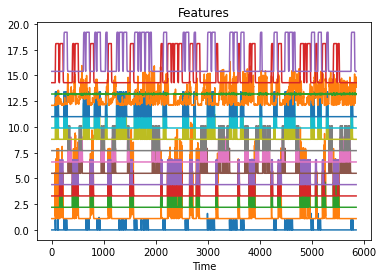

In [61]:
featureMat = np.asarray(dffCNN_content['designMat'])
featureMat_conv = np.zeros(featureMat.shape)
plt.figure()

for i in range(featureMat.shape[0]):
    x = np.copy(featureMat[i,])
    if i == [11,12]:
        featureMat_conv[i,] = x
        continue
    x = np.convolve(x,window2,'full')
    featureMat_conv[i,] = x[:featureMat.shape[1]]
    plt.plot(featureMat_conv[i,] + 1.1*i)
    
plt.xlabel('Time')
plt.title('Features')
plt.show()


In [62]:
#REGRESSION WITH CONVOLUTION FEATURES

from sklearn.linear_model import LinearRegression

correlation_convfeature =[]

X_train = featureMat_conv[:,train_spl]
X_test = featureMat_conv[:,test_spl]

correlation_convfeature = [] 

for i in range(numNeurons):
    y_train = neuronMat[i,train_spl]
    y_test = neuronMat[i,test_spl]
    reg = LinearRegression().fit(np.transpose(X_train), np.transpose(y_train))
    ypred = reg.predict(np.transpose(X_test))
    pearson_results = pearsonr(ypred,y_test)
    correlation_convfeature.append(pearson_results)
    pd.DataFrame(correlation_convfeature).to_csv('Total_Neuron_Pearson_R_convFeatures.csv')

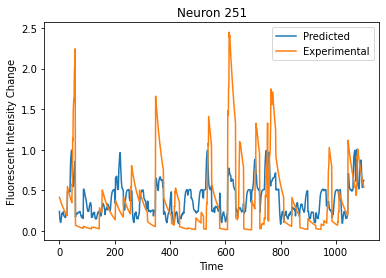

In [63]:

X_train = featureMat_conv[:,train_spl]
X_test = featureMat_conv[:,test_spl]

i = 548;
y_train = neuronMat[i,train_spl]
y_test = neuronMat[i,test_spl]
reg = LinearRegression().fit(np.transpose(X_train), np.transpose(y_train))
ypred = reg.predict(np.transpose(X_test))
    
plt.plot((ypred))
plt.plot((y_test))
plt.xlabel('Time')
plt.ylabel('Fluorescent Intensity Change')
plt.title('Neuron %d' % 251)
plt.legend(['Predicted', 'Experimental'])


plt.show()

In [64]:
#POLYFIT EXPANSION OF FEATURE

from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2, include_bias=False)
X2 = poly.fit_transform(np.transpose(featureMat_conv))
X2 = np.transpose(X2)

from sklearn.linear_model import LinearRegression

correlation_convfeature =[]

X_train = X2[:,train_spl]
X_test = X2[:,test_spl]

correlation_convfeature_poly = [] 

for i in range(numNeurons):
    y_train = neuronMat[i,train_spl]
    y_test = neuronMat[i,test_spl]
    reg = LinearRegression().fit(np.transpose(X_train), np.transpose(y_train))
    ypred = reg.predict(np.transpose(X_test))
    pearson_results = pearsonr(ypred,y_test)
    correlation_convfeature_poly.append(pearson_results)
    pd.DataFrame(correlation_convfeature_poly).to_csv('Total_Neuron_Pearson_R_convFeatures_polynomialExpansion.csv')

(0.6001091264605073, 1.3646150291352435e-111)

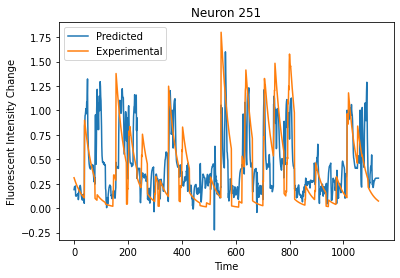

In [34]:
from sklearn.linear_model import LinearRegression


X_train = X2[:,train_spl]
X_test = X2[:,test_spl]
y_train = neuronMat[548,train_spl]
y_test = neuronMat[548,test_spl]
reg = LinearRegression().fit(np.transpose(X_train), np.transpose(y_train))
ypred = reg.predict(np.transpose(X_test))
    
plt.plot((ypred))
plt.plot((y_test))
plt.xlabel('Time')
plt.ylabel('Fluorescent Intensity Change')
plt.title('Neuron %d' % 251)
plt.legend(['Predicted', 'Experimental'])

pearsonr(ypred,y_test)